In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('results.csv')

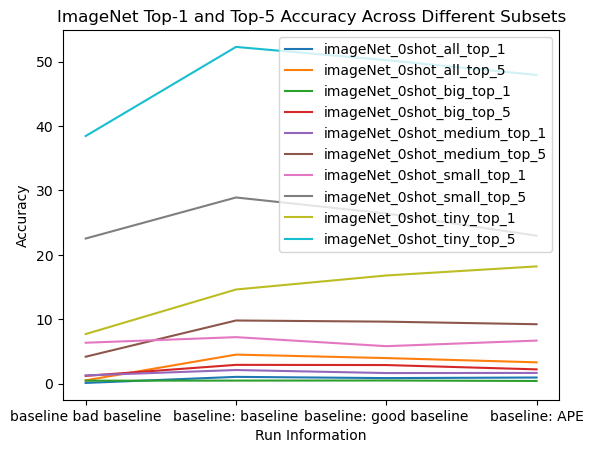

In [3]:
# Extract relevant columns
categories = ['all', 'big', 'medium', 'small', 'tiny']
top_1 = ['imageNet_0shot_{}_top_1'.format(cat) for cat in categories]
top_5 = ['imageNet_0shot_{}_top_5'.format(cat) for cat in categories]

# Plot
for col in df.columns:
    if col.startswith('imageNet'):
        plt.plot(df['info_about_run'], df[col], label=col)

plt.xlabel('Run Information')
plt.ylabel('Accuracy')
plt.title('ImageNet Top-1 and Top-5 Accuracy Across Different Subsets')
plt.legend()
plt.show()

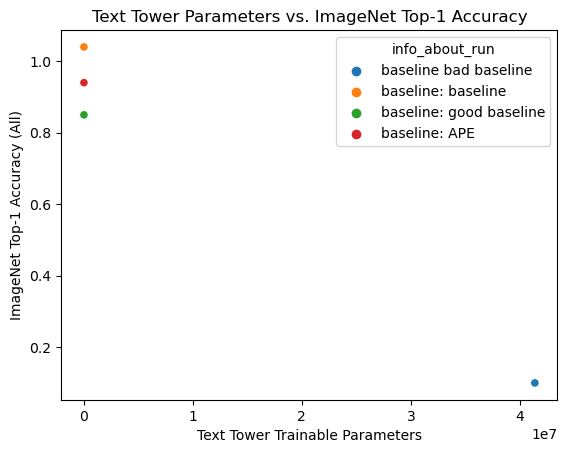

In [4]:
import seaborn as sns

# Scatter plot of text tower parameters vs. ImageNet top-1 accuracy
sns.scatterplot(data=df, x='text_tower_trainable_params', y='imageNet_0shot_all_top_1', hue='info_about_run')
plt.xlabel('Text Tower Trainable Parameters')
plt.ylabel('ImageNet Top-1 Accuracy (All)')
plt.title('Text Tower Parameters vs. ImageNet Top-1 Accuracy')
plt.show()

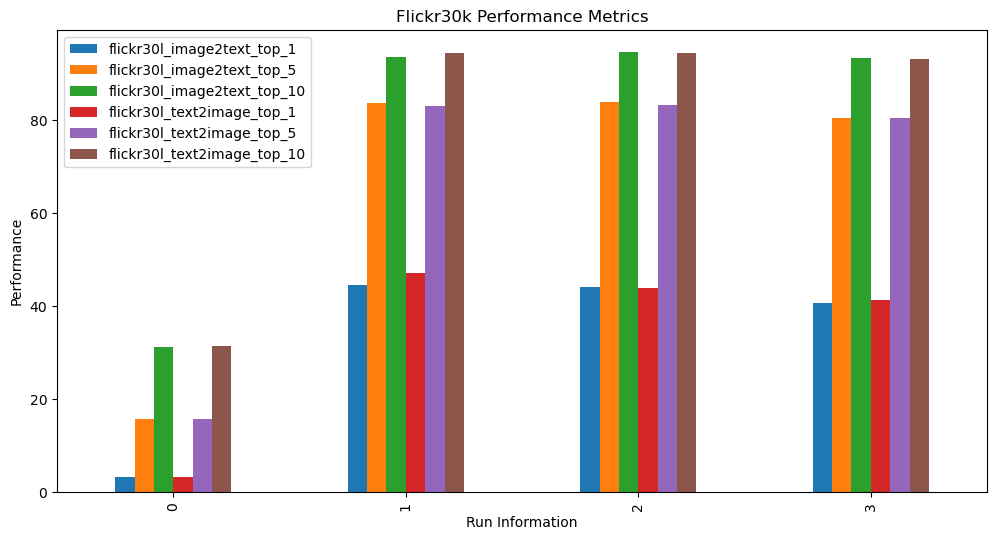

In [5]:
metrics = ['flickr30l_image2text_top_1', 'flickr30l_image2text_top_5', 'flickr30l_image2text_top_10', 
           'flickr30l_text2image_top_1', 'flickr30l_text2image_top_5', 'flickr30l_text2image_top_10']

df_metrics = df[metrics]
df_metrics.plot(kind='bar', figsize=(12, 6))

plt.xlabel('Run Information')
plt.ylabel('Performance')
plt.title('Flickr30k Performance Metrics')
plt.legend(metrics)
plt.show()

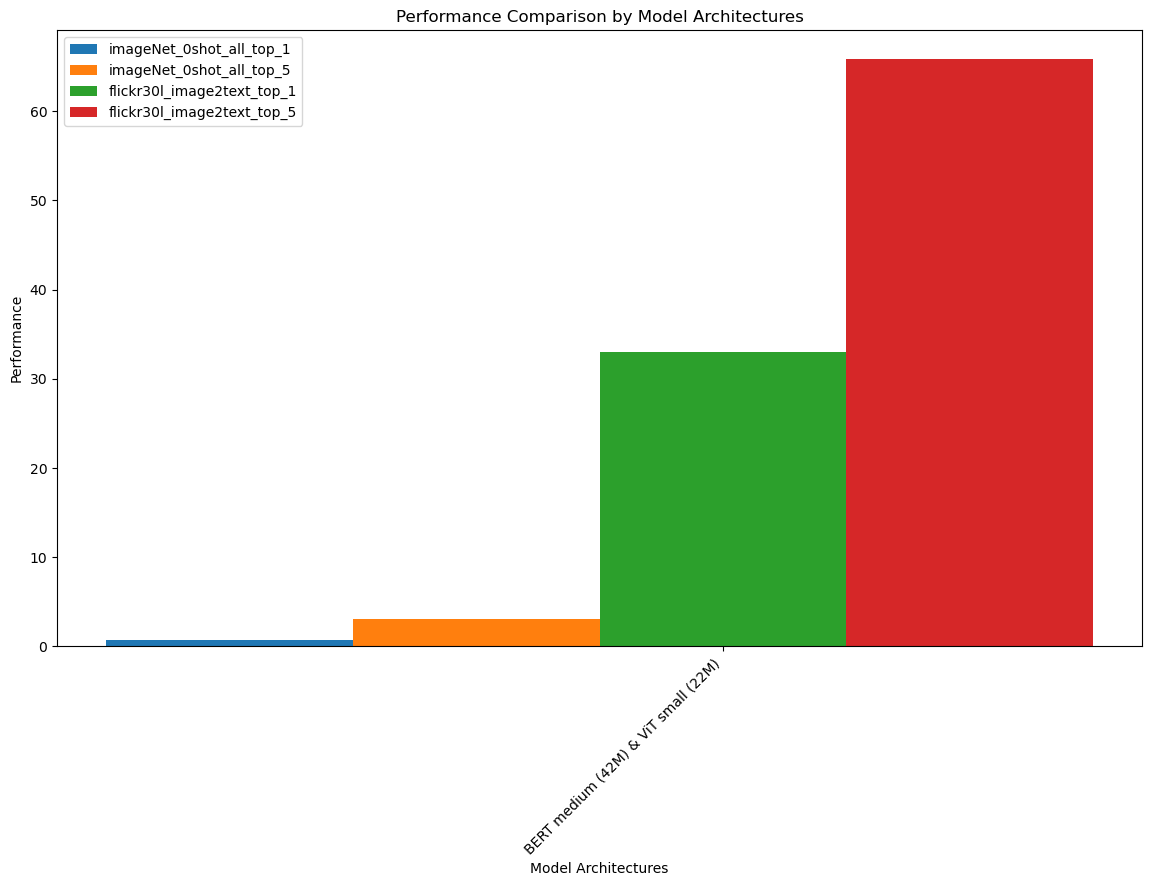

In [6]:
import numpy as np

architectures = df[['text_tower_name', 'image_tower_name']].drop_duplicates()
performance_metrics = ['imageNet_0shot_all_top_1', 'imageNet_0shot_all_top_5', 
                       'flickr30l_image2text_top_1', 'flickr30l_image2text_top_5']

fig, ax = plt.subplots(figsize=(14, 8))

index = np.arange(len(architectures))
bar_width = 0.2

for i, metric in enumerate(performance_metrics):
    ax.bar(index + i * bar_width, df.groupby(['text_tower_name', 'image_tower_name'])[metric].mean(), 
           bar_width, label=metric)

ax.set_xlabel('Model Architectures')
ax.set_ylabel('Performance')
ax.set_title('Performance Comparison by Model Architectures')
ax.set_xticks(index + bar_width / 2 * len(performance_metrics))
ax.set_xticklabels(architectures.apply(lambda x: f'{x[0]} & {x[1]}', axis=1))
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
df

In [1]:
'''import csv

# Define the header for your CSV file
header = ["text_tower_name", "text_head_name","image_tower_name", "image_head_name",
          "text_tower_weight", "text_head_weight","image_tower_weight", "image_head_weight",
          "text_tower_params", "text_head_params","image_tower_params", "image_head_params",
          "text_tower_trainable_params", "text_head_trainable_params","image_tower_trainable_params", "image_head_trainable_params",
          "imageNet_0shot_all_top_1","imageNet_0shot_all_top_5",
          "imageNet_0shot_big_top_1","imageNet_0shot_big_top_5",
          "imageNet_0shot_medium_top_1","imageNet_0shot_medium_top_5",
          "imageNet_0shot_small_top_1","imageNet_0shot_small_top_5",
          "imageNet_0shot_tiny_top_1","imageNet_0shot_tiny_top_5",
          "flickr30l_image2text_top_1","flickr30l_image2text_top_5","flickr30l_image2text_top_10",
          "flickr30l_text2image_top_1","flickr30l_text2image_top_5","flickr30l_text2image_top_10"
          ]

# Define the name of your CSV file
file_name = 'results.csv'

# Write the header to the CSV file
with open(file_name, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)

print(f"Initial CSV file '{file_name}' created successfully with header: {header}")'''

Initial CSV file 'results.csv' created successfully with header: ['text_tower_name', 'text_head_name', 'image_tower_name', 'image_head_name', 'text_tower_weight', 'text_head_weight', 'image_tower_weight', 'image_head_weight', 'text_tower_params', 'text_head_params', 'image_tower_params', 'image_head_params', 'text_tower_trainable_params', 'text_head_trainable_params', 'image_tower_trainable_params', 'image_head_trainable_params', 'imageNet_0shot_all_top_1', 'imageNet_0shot_all_top_5', 'imageNet_0shot_big_top_1', 'imageNet_0shot_big_top_5', 'imageNet_0shot_medium_top_1', 'imageNet_0shot_medium_top_5', 'imageNet_0shot_small_top_1', 'imageNet_0shot_small_top_5', 'imageNet_0shot_tiny_top_1', 'imageNet_0shot_tiny_top_5', 'flickr30l_image2text_top_1', 'flickr30l_image2text_top_5', 'flickr30l_image2text_top_10', 'flickr30l_text2image_top_1', 'flickr30l_text2image_top_5', 'flickr30l_text2image_top_10']


## DataSet

In [1]:
from dataloader import get_dataloader
import config as CFG
from tokenizer import get_tokenizer,get_feature_extractor

In [2]:
from torchvision.datasets.utils import download_url


In [3]:
val = 'https://storage.googleapis.com/sfr-vision-language-research/datasets/flickr30k_val.json'
download_url(val,CFG.ann_root)

Using downloaded and verified file: ./flickr30k/flickr30k_val.json


## Model

In [1]:
1024%1000

24

In [2]:
8*500/60

66.66666666666667

In [5]:
from models import CLIPModel
from losses import CLIPLoss

In [4]:
from transformers import BertModel, BertConfig


In [11]:
test = CLIPModel()

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the

In [5]:
model_name = "prajjwal1/bert-medium"

In [6]:
model = BertModel.from_pretrained(model_name)


Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
model2 = BertModel(config=BertConfig.from_pretrained(model_name))

In [9]:
model3 = BertModel.from_pretrained(pretrained_model_name_or_path=model_name,config=BertConfig.from_pretrained(model_name))

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Not new

In [3]:
from dataset import get_dataset
from training import valid_one_epoch
import os
import config as CFG
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import wandb

In [6]:
transform_train = transforms.Compose([
            transforms.RandomCrop(224,pad_if_needed=True),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.444, 0.421, 0.385), 
                                 (0.285, 0.277, 0.286))])

In [7]:
tokenizer = get_tokenizer(CFG.text_model_name)
ds_train = get_dataset(tokenizer=tokenizer,transform=transform_train,split="train")
ds_val = get_dataset(tokenizer=tokenizer,transform=transform_train,split="val")
ds_test = get_dataset(tokenizer=tokenizer,transform=transform_train,split="test")

Using downloaded and verified file: ./flickr30k/flickr30k_train.json
Using downloaded and verified file: ./flickr30k/flickr30k_val.json
Using downloaded and verified file: ./flickr30k/flickr30k_test.json


In [12]:
print(ds_train.__getitem__(0)["image"].shape)
print(ds_train.__getitem__(0)["input_ids"].shape)
print(ds_val.__getitem__(0)["image"].shape)
print(ds_val.__getitem__(0)["input_ids"].shape)
print(ds_test.__getitem__(0)["image"].shape)
print(ds_test.__getitem__(0)["input_ids"].shape)


torch.Size([3, 224, 224])
torch.Size([128])
torch.Size([3, 224, 224])
torch.Size([128])
torch.Size([3, 224, 224])
torch.Size([128])


In [2]:
dataloader_valid = get_dataloader(tokenizer=tokenizer,batch_size=CFG.batch_size,shuffle=CFG.shuffle_train,num_workers=CFG.num_workers,split="val")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CLIPModel().to(device)
loss_fn = CLIPLoss()

NameError: name 'get_dataloader' is not defined

In [17]:
wandb.init(project="master_test_1",
           config={
               "batch_size": CFG.batch_size,
               "learning_rate": CFG.head_lr,
               "dataset": "flickr30k",
           },
           group="group_test")
    
valid_loss = valid_one_epoch(model,loss_fn,dataloader_valid,device)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: carrelv. Use `wandb login --relogin` to force relogin


100%|██████████| 1/1 [00:05<00:00,  5.84s/it, valid_loss=6.94]


In [21]:
valid_loss.avg_text_l

tensor([[-0.0927,  0.3875, -0.1741,  ...,  0.0377,  0.0927, -0.1575],
        [-0.1718,  0.1364, -0.2955,  ..., -0.2148, -0.1264, -0.2588],
        [-0.0938,  0.0679, -0.3672,  ...,  0.0347,  0.0078, -0.3171],
        ...,
        [-0.3468,  0.3004, -0.2342,  ..., -0.1646, -0.2120, -0.2403],
        [-0.0600,  0.5362,  0.0269,  ..., -0.0285,  0.1017, -0.2270],
        [-0.2309,  0.0847, -0.0814,  ..., -0.4008, -0.2727, -0.2470]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [6]:
tokenizer = get_tokenizer(CFG.text_model_name)
feature_extractor = get_feature_extractor(CFG.vision_model_name)

dataloader_train = get_dataloader(tokenizer=tokenizer,feature_extractor=feature_extractor,batch_size=CFG.batch_size,shuffle=CFG.shuffle_train,num_workers=CFG.num_workers,split="train")
dataloader_valid = get_dataloader(tokenizer=tokenizer,feature_extractor=feature_extractor,batch_size=CFG.batch_size,shuffle=CFG.shuffle_train,num_workers=CFG.num_workers,split="val")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CLIPModel().to(device)
loss_fn = CLIPLoss()

Using downloaded and verified file: ./flickr30k/flickr30k_train.json
Using downloaded and verified file: ./flickr30k/flickr30k_val.json


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the

In [16]:
test = next(iter(dataloader_train))

In [17]:
test["image"].shape

torch.Size([1024, 1, 3, 224, 224])

In [11]:

transform_train = transforms.Compose([
            transforms.RandomCrop(224,pad_if_needed=True),
            transforms.RandomHorizontalFlip(), 
            ])

In [12]:
dataset = get_dataset(tokenizer=tokenizer,feature_extractor=feature_extractor,transform=transform_train,split="train")

Using downloaded and verified file: ./flickr30k/flickr30k_train.json


In [13]:
test = dataset.__getitem__(0)

In [15]:
test["image"].shape

torch.Size([1, 3, 224, 224])

In [38]:
test["input_ids"].shape

torch.Size([128])

In [28]:
test["image"][0].shape

torch.Size([1024, 3, 224, 224])

## DDP

In [7]:
from torchvision.datasets.utils import download_url
from torch.utils.data import  Dataset
import json
from dataset import pre_caption
import config as CFG
from torchvision.datasets import Flickr30k
import random

In [38]:

class flickr30k_test(Dataset):
    def __init__(self, tokenizer,transform,image_root, ann_root, split, max_words=CFG.max_length, prompt=CFG.prompt):        
        '''
        image_root (string): Root directory of images (e.g. data/)
        ann_root (string): directory to store the annotation file
        split (string): one of "train" or "test"
        '''        
        train = 'https://storage.googleapis.com/sfr-vision-language-research/datasets/flickr30k_train.json'
        test = 'https://storage.googleapis.com/sfr-vision-language-research/datasets/flickr30k_test.json'

        self.tokenizer = tokenizer

        self.split = split
        assert self.split in ("train","test")

        if self.split == "train":
            url = train
            filename = 'flickr30k_train.json'
        else:
            url = test
            filename = 'flickr30k_test.json'

        download_url(url,ann_root)
        
        self.annotation = json.load(open(os.path.join(ann_root,filename),'r'))
        self.transform = transform
        self.image_root = image_root
        self.max_words = max_words      
        self.prompt = prompt
        
        self.img_ids = {} 

        for ann in self.annotation:
            img_id = ann['image_id']
            if img_id not in self.img_ids.keys():
                self.img_ids[img_id] = ann
                self.img_ids[img_id]["caption"] = [self.img_ids[img_id]["caption"]]
            
            else: 
                ls = self.img_ids[img_id]["caption"]
                ls.append(ann["caption"])               
                self.img_ids[img_id]["caption"] = ls

        self.annotation = None
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, index):    
        
        item = self.img_ids[index]
        
        image_path = os.path.join(self.image_root,item['image'])        
        image = Image.open(image_path).convert('RGB')   
        image = self.transform(image)
        
        caption = self.prompt+pre_caption(random.choice(item['caption']), self.max_words)
        
        caption_encoded = self.tokenizer(caption,padding="max_length",max_length=self.max_words)

        return {"image" :image, "input_ids": torch.as_tensor(caption_encoded["input_ids"]), "attention_mask": torch.as_tensor(caption_encoded["attention_mask"])}

In [39]:
ds = flickr30k_test(tokenizer=tokenizer,transform=transform_train,image_root=CFG.image_root,ann_root=CFG.ann_root,split="train")

Using downloaded and verified file: ./flickr30k/flickr30k_train.json


In [40]:
ds.__getitem__(0)

NameError: name 'Image' is not defined

In [36]:
random.choice(ds.img_ids[0]["caption"])

'Two young, White males are outside near many bushes.'

In [31]:
from dataset import flickr30k

In [32]:
ds2 = flickr30k(tokenizer=tokenizer,transform=transform_train,image_root=CFG.image_root,ann_root=CFG.ann_root,split="train")

Using downloaded and verified file: ./flickr30k/flickr30k_train.json


In [25]:
ds2.annotation[:5]

[{'image': 'flickr30k-images/1000092795.jpg',
  'caption': 'Two young guys with shaggy hair look at their hands while hanging out in the yard.',
  'image_id': 0},
 {'image': 'flickr30k-images/1000092795.jpg',
  'caption': 'Two young, White males are outside near many bushes.',
  'image_id': 0},
 {'image': 'flickr30k-images/1000092795.jpg',
  'caption': 'Two men in green shirts are standing in a yard.',
  'image_id': 0},
 {'image': 'flickr30k-images/1000092795.jpg',
  'caption': 'A man in a blue shirt standing in a garden.',
  'image_id': 0},
 {'image': 'flickr30k-images/1000092795.jpg',
  'caption': 'Two friends enjoy time spent together.',
  'image_id': 0}]